In [652]:
import torch
from torch import nn

### **Neural Network Classification with PyTorch**
- Predicting whether something is one thing or another

## **1. Make classification data**

In [653]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [654]:
X[:5], y[:5] 
# 2 features and 2 labels (1 or 0)

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [655]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0], 
                        'X2': X[:, 1], 
                        'label': y}) # A dictionary

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


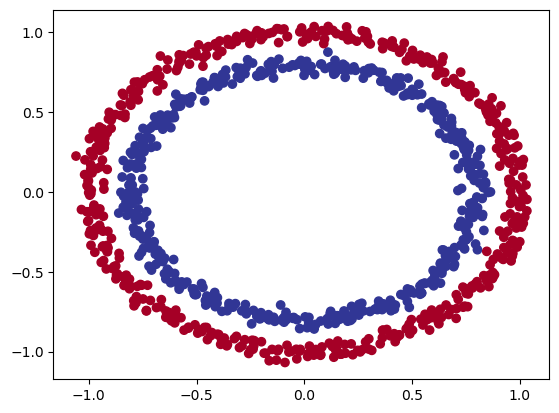

In [656]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y, # Assign color based on values in y (labels)
            cmap=plt.cm.RdYlBu);

# Each color represents a label

**Note**: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to pratice the fundamentals

In [657]:
# Checking input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [658]:
# View fist example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values of a sample of X: {X_sample} and y: {y_sample}')
print(f'Shape of a sample of X: {X_sample.shape} and y: {y_sample.shape}')

Values of a sample of X: [0.75424625 0.23148074] and y: 1
Shape of a sample of X: (2,) and y: ()


1.2 Convert to Tensors and Create test-train splits

In [659]:
X.dtype, y.dtype # float64, int64 means NumPy Array

(dtype('float64'), dtype('int64'))

In [660]:
# Turn to Tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [661]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [662]:
X[:5], y[:5] # Now Tensors

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [663]:
# Split data into test and training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

**2. Building a model**
Let's build a model to classify our blue and red dots.

2.1. Setup device agnostic code 

2.2. Construct a model (By subclassing `nn.Module`)

2.3. Define loss function and optimizer

2.4. Create a training and test loop


In [664]:
# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device in use: ', device)

print('Device Count: ', torch.cuda.device_count())

Device in use:  cuda
Device Count:  1


### Model Creation - Sub class `nn.Module`
- Create 2 `nn.Linear()` layers that are capable of handling shapes of our data

- Define a `foward()` method that outlines the forward pass of the model

- Instantiate an instance of our model calss and send it the target `device`

In [665]:
# Model Construction 
sequential = 0

if not sequential:
    class CircleModelV0(nn.Module): # Can be made custom
        def __init__(self):
            super().__init__()
            # Create 2 nn.Linear layers: Training (800,2)
            self.layer_one = nn.Linear(in_features=2, out_features=5)
            # Layer one takes 2 features and upscales to 5 hidden features (Multiple of 8s preferred)
            # Hidden features, more to learn, does have an upper limit
            self.layer_two = nn.Linear(in_features=5, out_features=1)
            # Layer two must take in features equal to no. of out features from previous layer

            # OR
            '''
            self.two_linear_layers = nn.Sequential(
                nn.Linear(in_features=2, out_features=5),
                nn.Linear(in_features=5, out_features=1)
            )
            '''

        def forward(self, x):
            return self.layer_two(self.layer_one(x))
            # x -> Layer 1 -> Layer 2 -> Output

else:
    modelV0 = nn.Sequential( # Automated
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
    ).to(device)

if not sequential:
    modelV0 = CircleModelV0()
    modelV0.to(device)
    print(modelV0)

else:
    print(modelV0)

CircleModelV0(
  (layer_one): Linear(in_features=2, out_features=5, bias=True)
  (layer_two): Linear(in_features=5, out_features=1, bias=True)
)


In [666]:
# Parameters are on the GPU 
next(modelV0.parameters()), next(modelV0.parameters()).device

(Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188]], device='cuda:0', requires_grad=True),
 device(type='cuda', index=0))

In [667]:
# Predictions
modelV0.state_dict() # Layer 1: (2,5), Layer 2: (5, 1)

OrderedDict([('layer_one.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_one.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_two.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer_two.bias', tensor([-0.2060], device='cuda:0'))])

In [668]:
with torch.inference_mode(): # Removes gradient tracking, faster computations
    untrained_y_preds = modelV0(X_test.to(device))
print(f'Length of untrained predictions: {len(untrained_y_preds)} and Shape of untrained predictions: {untrained_y_preds.shape}')
print(f'Length of test samples: {len(X_test)} and Shape of test samples: {X_test.shape}')

Length of untrained predictions: 200 and Shape of untrained predictions: torch.Size([200, 1])
Length of test samples: 200 and Shape of test samples: torch.Size([200, 2])


In [669]:
X_test[:10]

tensor([[-0.3752,  0.6827],
        [ 0.0154,  0.9600],
        [-0.7028, -0.3147],
        [-0.2853,  0.9664],
        [ 0.4024, -0.7438],
        [ 0.6323, -0.5711],
        [ 0.8561,  0.5499],
        [ 1.0034,  0.1903],
        [-0.7489, -0.2951],
        [ 0.0538,  0.9739]])

In [670]:
untrained_y_preds[:10] # First 10 predictions

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='cuda:0')

In [671]:
y_test[:10] # First 10 labels

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

Logits - `nn.BCEWithLogitsLoss()` : Combines `nn.BCELoss()` and `nn.Sigmoid()`, Numerically Stable
Going from raw logits -> Prediction probabilities -> Prediction labels
Our models outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (a sigmoid for binary crossentropy and softmax for multiclassclassification).

Then, we can convert our model's prediction probabilities to **prediction labels** by eitherrounding (Binary) them or taking the `argmax()` (Softmax).

Just BCE - `nn.BCELoss()`

Activation Layers is different to just a layer.

In [672]:
# First 5 outputs of the forward pass on test data
modelV0.eval()
with torch.inference_mode():
    y_logits = modelV0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')

In [673]:
y_test[:5] # y_logits and y_test not in same format

tensor([1., 0., 1., 0., 1.])

In [674]:
# Use sigmoid activation function on logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs, torch.round(y_pred_probs) 
# Greater than equal to 0.5 -> 1 and less than 0.5 -> 0, this is called a Decision Boundary
# The range of the boundary can be adjusted

y_preds = torch.round(y_pred_probs)

In [675]:
# Full Code
modelV0.eval()
with torch.inference_mode():
    # Logits -> Pred Probs -> Pred Labels
    y_pred_labels = torch.round(torch.sigmoid(modelV0(X_test.to(device))[:5]))
    
print(torch.eq(y_preds, y_pred_labels)) # Can be squeezed
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([[True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')
tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [676]:
# Loss function and Optimizer
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built in (1/(1+e^(-x))) + nn.BCELoss()

optimizer = torch.optim.SGD(params=modelV0.parameters(),
                            lr=0.01)

**Calculate Accuracy - Evaluation Metrics**

Accuracy = *True Positive/(True Positive+True Negative)*

Out of a 100 examples, what percentage does our model get right?

In [677]:
tens1 = torch.tensor([1,2,3,4,6])
tens2 = torch.tensor([2,2,3,5,7])

# Sum of Trues
torch.eq(tens1, tens2).sum().item() # Just prints out 2 instead of tensor(2)

2

In [678]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # y_true equals to y_pred, summed up and item() for a single value
    acc = correct/len(y_pred) * 100
    return acc

### Training Loop Starting



In [679]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

# Set no. of epochs
epochs = 1000

# Data agnostic code
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop 
for epoch in range(epochs):
    
    modelV0.train()

    # 1. Forward Pass
    y_logits = modelV0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss/accuracy, BCELogitsWithLoss expects logits so we get logits in forward pass
    loss = loss_fn(y_logits,
                   y_train) 
    
    # If we used BCE Loss, expects Prediction Probabilities, so we convert logits using sigmoid
    ''' 
    loss_BCE = nn.BCELoss()
    loss = loss_BCE(torch.sigmoid(y_logits),
                   y_train)
    '''

    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred) # y_pred labels
    
    # 3. Optimize Zero Grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    # Testing
    modelV0.eval()

    with torch.inference_mode():
        test_logits = modelV0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

    # Test loss and accuracy
    test_loss = loss_fn(test_logits, y_test) # Expects logits, (pred, true)
    test_acc = accuracy_fn(y_test, test_pred) # Expects labels, (true, pred)

    # Process
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:5f} | Accuracy: {acc:2f}% | Test Loss: {test_loss:5f} | Test Accuracy: {test_acc:2f}%')

Epoch: 0 | Loss: 0.695685 | Accuracy: 50.000000% | Test Loss: 0.697385 | Test Accuracy: 50.000000%
Epoch: 10 | Loss: 0.695439 | Accuracy: 50.000000% | Test Loss: 0.697198 | Test Accuracy: 50.000000%
Epoch: 20 | Loss: 0.695215 | Accuracy: 50.000000% | Test Loss: 0.697031 | Test Accuracy: 50.000000%
Epoch: 30 | Loss: 0.695013 | Accuracy: 50.000000% | Test Loss: 0.696882 | Test Accuracy: 50.000000%
Epoch: 40 | Loss: 0.694831 | Accuracy: 50.000000% | Test Loss: 0.696750 | Test Accuracy: 50.000000%
Epoch: 50 | Loss: 0.694665 | Accuracy: 50.000000% | Test Loss: 0.696632 | Test Accuracy: 50.000000%
Epoch: 60 | Loss: 0.694516 | Accuracy: 50.000000% | Test Loss: 0.696528 | Test Accuracy: 50.000000%
Epoch: 70 | Loss: 0.694381 | Accuracy: 50.000000% | Test Loss: 0.696436 | Test Accuracy: 50.000000%
Epoch: 80 | Loss: 0.694258 | Accuracy: 50.000000% | Test Loss: 0.696354 | Test Accuracy: 50.000000%
Epoch: 90 | Loss: 0.694148 | Accuracy: 50.000000% | Test Loss: 0.696281 | Test Accuracy: 50.000000%
E

In [680]:
# 4. Make Predictions and Evaluate - `plot_decision` boundary
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists!')
else:
    print("Download helper_functions.py")
    # Downloading Python Script from a website
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists!


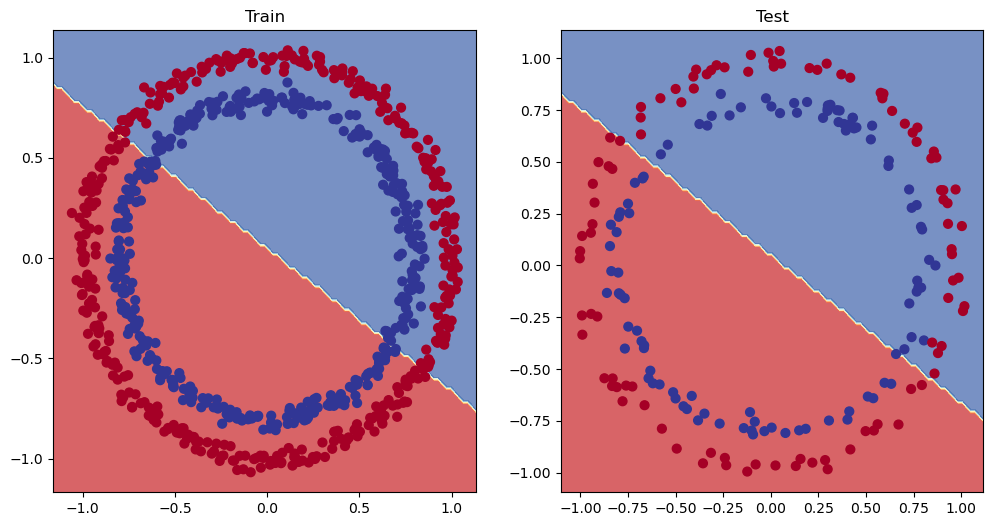

In [681]:
# Plot Decision Boundary 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # Rows Cols Index
plt.title('Train')
plot_decision_boundary(modelV0, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(modelV0, X_test, y_test)

# Model is trying to classify based on linearity since layers are linear
# But our data doesn't fit, we can try non-linear layers

### **5. Improving the model**

- Add more layers, more chances to learn about patterns in data

- Add more hidden layers, more things to learn

- Fit for longer

- Change activation function, we are using `sigmoid`

- Change learning rate

- Change loss function

All of these are from the model's perspective, since all changes deal with tweaking the model.

Exploding Gradients - Learning rate too high, gradient values become too high

Vanishing Gradients - Learning rate is too low, gradient values might equate to zero


In [682]:
# Combine Network Layers with Activation Functions
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_one = nn.Linear(in_features=2, out_features=10) # Increase Hidden Units
        self.layer_two = nn.Linear(in_features=10, out_features=10)
        self.layer_three = nn.Linear(in_features=10, out_features=1) # Output Layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        z = self.layer_one(x) # z -> Logits
        z = self.layer_two(z)
        z = self.layer_three(z)
        '''
        return self.layer_three(self.layer_two(self.layer_one(x))) # All in one
    
ModelV1 = CircleModelV1().to(device)
ModelV1

CircleModelV1(
  (layer_one): Linear(in_features=2, out_features=10, bias=True)
  (layer_two): Linear(in_features=10, out_features=10, bias=True)
  (layer_three): Linear(in_features=10, out_features=1, bias=True)
)

In [683]:
# Training Loop for ModelV1
loss_fn_V1 = nn.BCEWithLogitsLoss()

optimizer_V1 = torch.optim.SGD(params=ModelV1.parameters(),
                               lr=0.01)

In [684]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Device agnostic code
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    # Training Phase
    ModelV1.train()

    # 1. Forward pass
    y_logits = ModelV1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Logits -> Pred Probs -> Pred Labels

    # 2. Calculate the loss and accuracy
    loss_V1 = loss_fn(y_logits, y_train)

    acc_V1 = accuracy_fn(y_train, y_pred)

    # 3. Optimizer Zero Grad
    optimizer_V1.zero_grad()

    # 4. Backpropagation
    loss_V1.backward()

    # 5. Step Optimizer
    optimizer_V1.step()

    # Testing Phase
    ModelV1.eval()

    with torch.inference_mode():
        test_logits = ModelV1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss_V1 = loss_fn(test_logits, y_test)
        test_acc_V1 = accuracy_fn(y_test, test_pred)

        if epoch%50 == 0:
            print(f'Epochs: {epoch} | Train Loss: {loss_V1:.5f} | Train Accuracy: {acc_V1:.2f}% | Test Loss: {test_loss_V1:.5f} | Test Accuracy: {test_acc_V1:.2f}%')

Epochs: 0 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epochs: 50 | Train Loss: 0.69381 | Train Accuracy: 50.75% | Test Loss: 0.69264 | Test Accuracy: 50.50%
Epochs: 100 | Train Loss: 0.69369 | Train Accuracy: 50.25% | Test Loss: 0.69269 | Test Accuracy: 50.00%
Epochs: 150 | Train Loss: 0.69359 | Train Accuracy: 50.00% | Test Loss: 0.69275 | Test Accuracy: 50.50%
Epochs: 200 | Train Loss: 0.69351 | Train Accuracy: 50.12% | Test Loss: 0.69282 | Test Accuracy: 49.50%
Epochs: 250 | Train Loss: 0.69345 | Train Accuracy: 50.25% | Test Loss: 0.69288 | Test Accuracy: 50.50%
Epochs: 300 | Train Loss: 0.69339 | Train Accuracy: 50.50% | Test Loss: 0.69295 | Test Accuracy: 49.00%
Epochs: 350 | Train Loss: 0.69334 | Train Accuracy: 50.38% | Test Loss: 0.69302 | Test Accuracy: 49.00%
Epochs: 400 | Train Loss: 0.69329 | Train Accuracy: 50.38% | Test Loss: 0.69309 | Test Accuracy: 48.50%
Epochs: 450 | Train Loss: 0.69326 | Train Accuracy: 50.38% | Test L

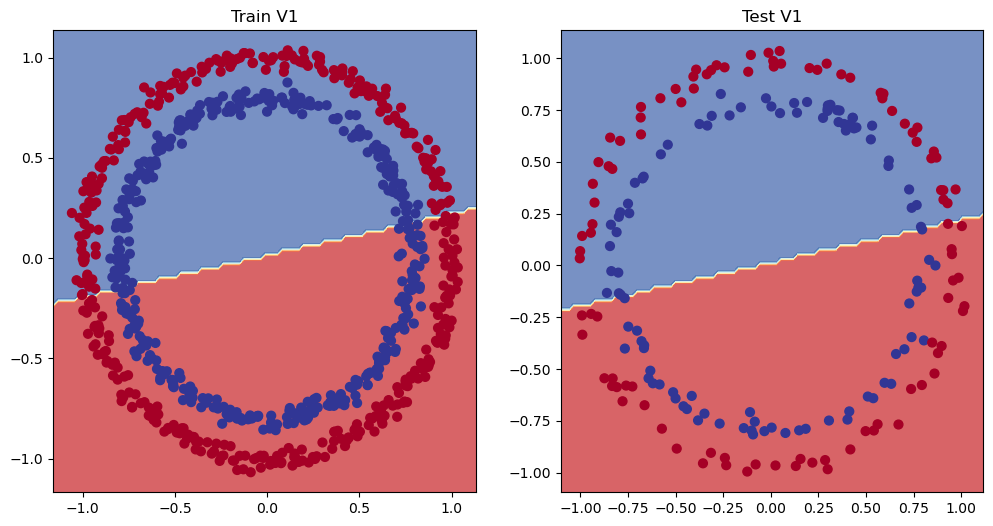

In [685]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Train V1')
plot_decision_boundary(ModelV1, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test V1')
plot_decision_boundary(ModelV1, X_test, y_test)

# Increasing layers and hidden units, doesn't help

### Prepare data to see if our model can fit a **straight  line**, is **Linear**

In [686]:
# Create some data 
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias


print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

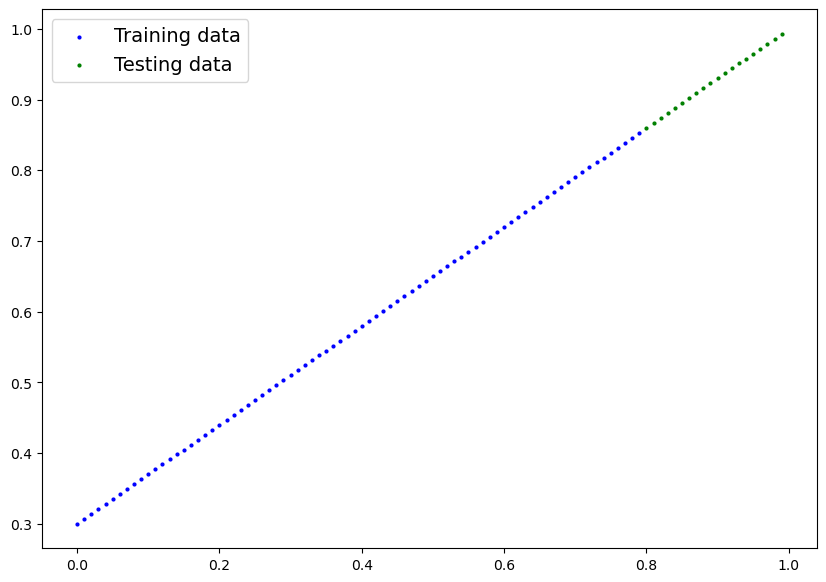

In [687]:
# Create train and test splits
train_split = int(0.8 *len(X_regression))
X_train_reg, y_train_reg = X_regression[:train_split], y_regression[:train_split]
X_test_reg, y_test_reg = X_regression[train_split:], y_regression[train_split:]

plot_predictions(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

In [688]:
ModelV1

CircleModelV1(
  (layer_one): Linear(in_features=2, out_features=10, bias=True)
  (layer_two): Linear(in_features=10, out_features=10, bias=True)
  (layer_three): Linear(in_features=10, out_features=1, bias=True)
)

In [689]:
# Adjust ModelV1 to fit straight line
ModelV2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

ModelV2.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [690]:
loss_fn_V2 = nn.L1Loss() # MAE
optimizer_V2 = torch.optim.SGD(params=ModelV2.parameters(),
                            lr=0.01)
# Train Model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
    ModelV2.train()

    y_pred = ModelV2(X_train_reg)
    loss_V2 = loss_fn_V2(y_pred, y_train_reg)

    optimizer_V2.zero_grad()
    loss_V2.backward()

    optimizer_V2.step()

    ModelV2.eval()
    with torch.inference_mode():
        test_pred = ModelV2(X_test_reg)
        test_loss_V2 = loss_fn_V2(test_pred, y_test_reg)

    if epoch%100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss_V2:.5f} | Test Loss: {test_loss_V2:.5f}')

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


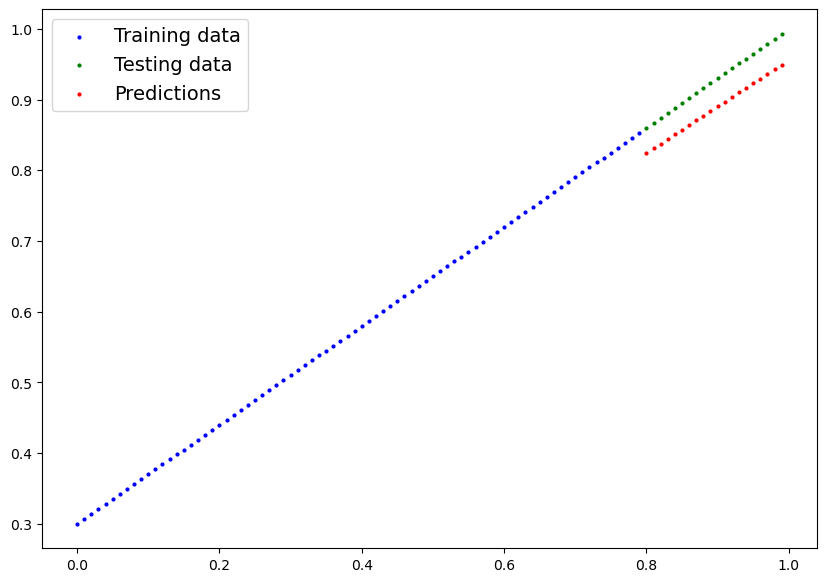

In [691]:
ModelV2.eval()
with torch.inference_mode():
    test_pred = ModelV2(X_test_reg)

plot_predictions(X_train_reg.cpu(), y_train_reg.cpu(), X_test_reg.cpu(), y_test_reg.cpu(), test_pred.cpu())

### **Use Non-linearity**

Non-straight lines, curves and such

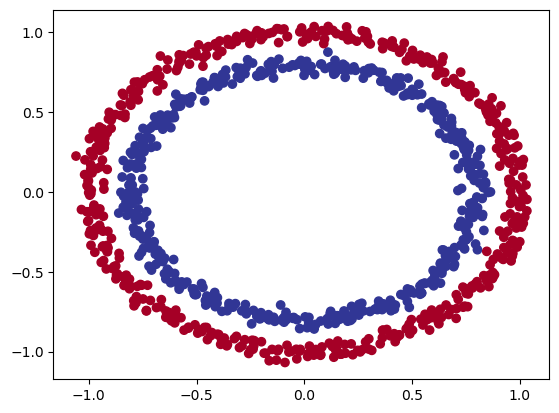

In [692]:
# Recreate non-linear data (Red and Blue circles)
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [693]:
# Convert data to tensors then train test splits
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [694]:
y_train[:5], y_test[:5]

(tensor([1., 0., 0., 0., 1.]), tensor([1., 0., 1., 0., 1.]))

### Neural Network with Non-linearity

Layers in NN are combination of `nn` functions

Popular Activations - `ReLU`, `tanh`, `Sigmoid`, `Linear`

In [695]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_one = nn.Linear(in_features=2, out_features=10)
        self.layer_two = nn.Linear(in_features=10, out_features=10)
        self.layer_three = nn.Linear(in_features=10, out_features=1)

        self.relu = nn.ReLU() # Rectified Linear Unit: Non-linear activation function, all negatives to zero

    def forward(self, x: torch.Tensor) -> torch.Tensor: # ReLU between each layer
        return self.layer_three(self.relu(self.layer_two(self.relu(self.layer_one(x)))))
    
ModelV3 = CircleModelV2().to(device)
ModelV3

CircleModelV2(
  (layer_one): Linear(in_features=2, out_features=10, bias=True)
  (layer_two): Linear(in_features=10, out_features=10, bias=True)
  (layer_three): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [696]:
# Setup loss and optimizer

loss_fn_V3 = nn.BCEWithLogitsLoss()

optimizer_V3 = torch.optim.SGD(params=ModelV3.parameters(),
                               lr=0.1)

In [697]:
ModelV3.state_dict() # 

OrderedDict([('layer_one.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_one.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_two.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, 

In [698]:
# Data to device 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 2000

for epoch in range(epochs):

    # Training Phase
    ModelV3.train()

    # Forward Pass
    y_logits = ModelV3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss
    lossV3 = loss_fn_V3(y_logits, y_train)
    accV3 = accuracy_fn(y_train, y_pred)

    # Optimizer Zero Grad
    optimizer_V3.zero_grad()

    # Backprop
    lossV3.backward()

    # Optimizer Step 
    optimizer_V3.step()

    # Testing Phase
    ModelV3.eval()

    with torch.inference_mode():
        test_logits = ModelV3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_lossV3 = loss_fn_V3(test_logits, y_test)
        test_accV3 = accuracy_fn(y_test, test_pred)
    
    if epoch%100 == 0:
        print(f'Epoch: {epoch} | Loss: {lossV3:.5f} | Accuracy: {accV3:.2f}% | Test Loss: {test_lossV3:.5f} | Test Accuracy: {test_accV3:.2f}%')

Epoch: 0 | Loss: 0.69295 | Accuracy: 50.00% | Test Loss: 0.69319 | Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115 | Accuracy: 52.88% | Test Loss: 0.69102 | Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977 | Accuracy: 53.37% | Test Loss: 0.68940 | Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795 | Accuracy: 53.00% | Test Loss: 0.68723 | Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517 | Accuracy: 52.75% | Test Loss: 0.68411 | Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102 | Accuracy: 52.75% | Test Loss: 0.67941 | Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515 | Accuracy: 54.50% | Test Loss: 0.67285 | Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659 | Accuracy: 58.38% | Test Loss: 0.66322 | Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160 | Accuracy: 64.00% | Test Loss: 0.64757 | Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362 | Accuracy: 74.00% | Test Loss: 0.62145 | Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818 | Accuracy: 87.75% | Test Loss: 0.57378 | Test Accuracy: 86.50%


In [699]:
# Evaluation 
ModelV3.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(ModelV3(X_test))).squeeze()
y_preds[:5], y_test[:5]

(tensor([1., 0., 1., 0., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

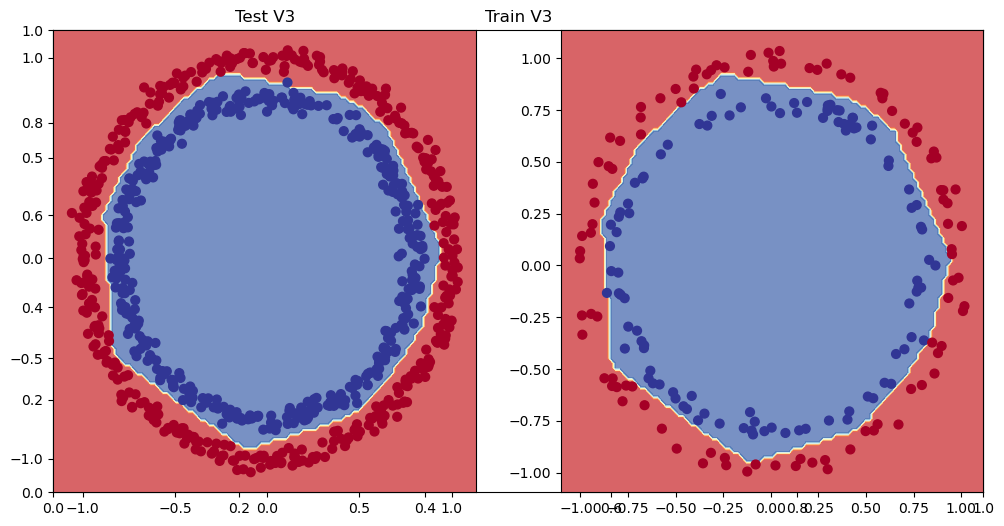

In [700]:
# Plot Decision Boundary
plt.figure(figsize=(12, 6))
plt.title('Train V3')
plt.subplot(1,2,1)
plot_decision_boundary(ModelV3, X_train, y_train)

plt.title('Test V3')
plt.subplot(1,2,2)
plot_decision_boundary(ModelV3, X_test, y_test)

### **Neural Network** is a big stack of linear and non-linear functions, we provide data and labels and the model find pattern in them.

- Replicating non-liner activation functions

In [701]:
A = torch.arange(-10, 10, 1).type(torch.float)
A.dtype, A

(torch.float32,
 tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]))

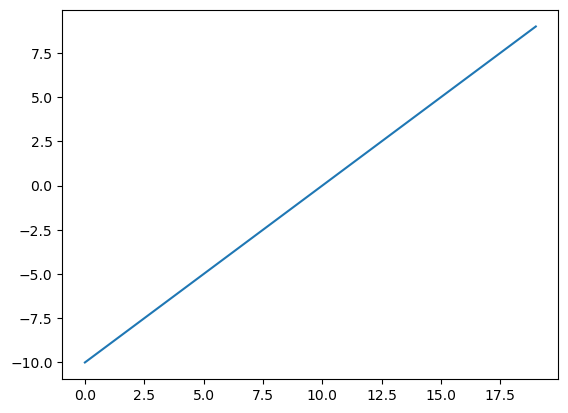

In [702]:
# Visualize 
plt.plot(A)

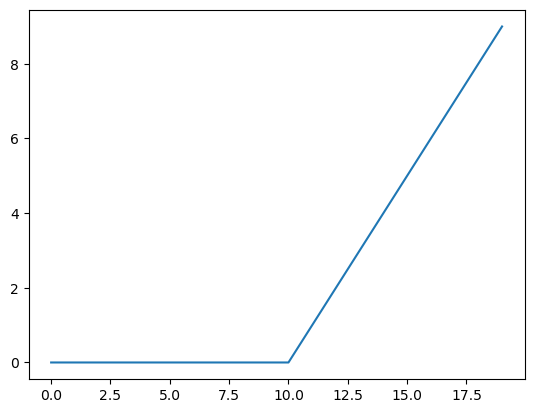

In [703]:
plt.plot(torch.relu(A)) # All negatives grounded to zero

In [704]:
# ReLU
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

([<matplotlib.lines.Line2D at 0x25b6be0b890>],
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
         8., 9.]))

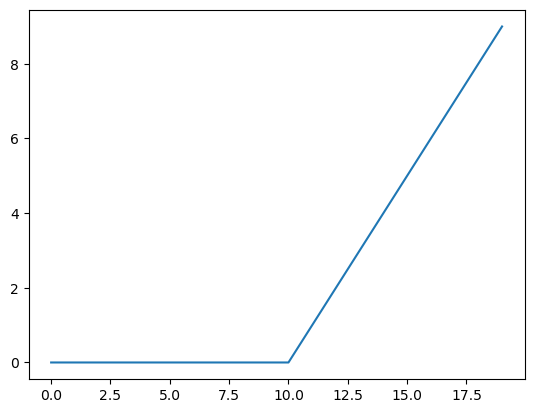

In [705]:
plt.plot(relu(A)), relu(A)

In [706]:
torch.sigmoid(A) #

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

In [707]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1+torch.exp(-x))

In [708]:
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

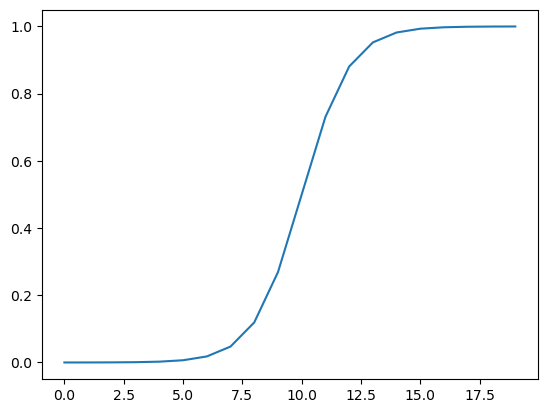

In [709]:
plt.plot(sigmoid(A))

### ***Mutli-class Classification***

In [710]:
# Putting it all together but for multi-class classification (More than 2 classes)
'''
Use softmax() and Crossentropy
'''

# Create a toy dataset
from sklearn.datasets import make_blobs

# Hyperparams for dataset
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob_np, y_blob_np = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob_np).type(torch.float) 

y_blob = torch.from_numpy(y_blob_np).type(torch.LongTensor) 
# `y_blob` has to be kept as LongTensor

X_blob, y_blob

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         ...,
         [ 3.2158,  5.9217],
         [-7.7939, -7.1606],
         [-9.6816,  7.0097]]),
 tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 3, 0, 2, 2, 2, 0, 0, 0, 1, 1, 3, 3, 3,
         1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 3, 2, 1, 3, 3, 1, 2, 1, 3, 1, 3, 0, 1,
         3, 1, 2, 0, 1, 3, 0, 3, 0, 0, 0, 2, 2, 0, 2, 3, 1, 0, 2, 2, 1, 0, 3, 0,
         1, 2, 1, 3, 1, 0, 1, 0, 2, 0, 0, 0, 1, 3, 2, 2, 0, 0, 0, 0, 1, 1, 3, 1,
         3, 0, 1, 2, 1, 3, 3, 0, 3, 1, 1, 0, 2, 0, 3, 2, 1, 1, 1, 1, 2, 3, 2, 1,
         0, 2, 3, 1, 3, 2, 1, 3, 2, 1, 0, 2, 1, 3, 1, 3, 0, 2, 1, 1, 0, 0, 3, 3,
         3, 1, 1, 0, 0, 0, 0, 3, 2, 2, 0, 1, 0, 1, 1, 3, 2, 0, 1, 2, 0, 0, 1, 2,
         3, 2, 1, 0, 0, 1, 0, 3, 2, 3, 2, 3, 1, 1, 0, 2, 0, 2, 1, 3, 0, 2, 1, 0,
         1, 1, 0, 3, 2, 2, 2, 3, 0, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 3, 2, 2, 1, 0,
         2, 0, 3, 1, 3, 3, 2, 0, 3, 0, 1, 2, 2, 0, 0, 2, 0, 3, 2, 2, 3, 2, 2, 1,


In [711]:
# TTS
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.3, random_state=RANDOM_SEED)

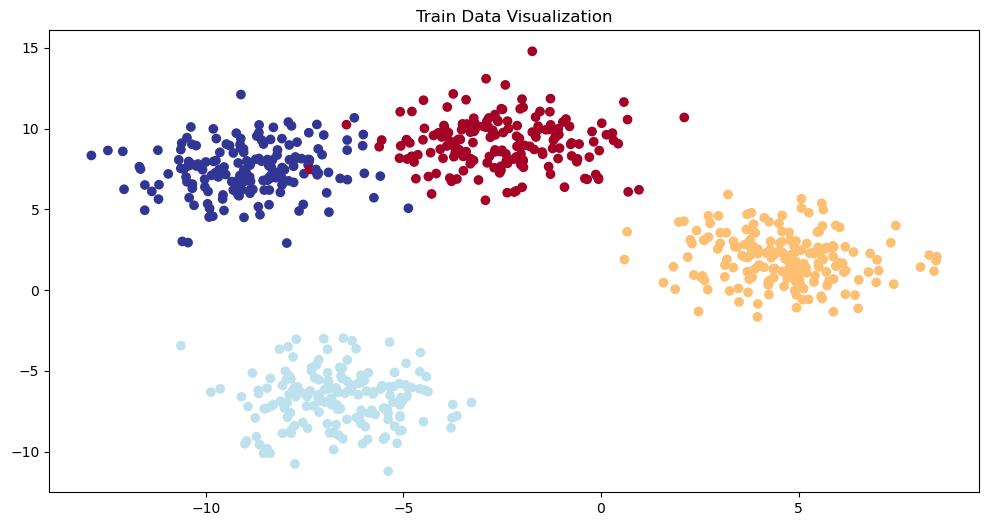

In [712]:
# Plot 
plt.figure(figsize=(12,6))
# Spread of blobs dependent on `cluster_std`
plt.title("Train Data Visualization")
plt.scatter(X_blob_train[:, 0], X_blob_train[:, 1], c=y_blob_train, cmap=plt.cm.RdYlBu)

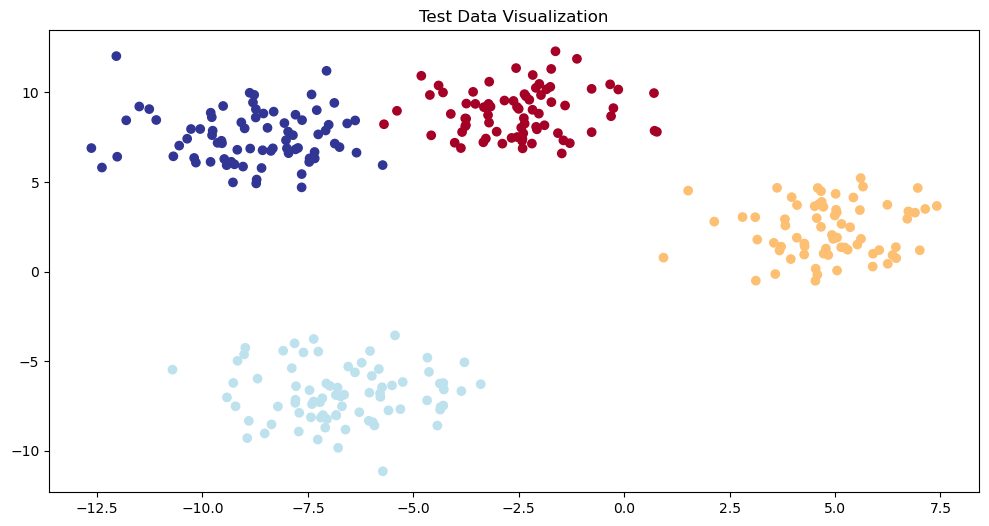

In [713]:
plt.figure(figsize=(12,6))
plt.title('Test Data Visualization')
plt.scatter(X_blob_test[:, 0], X_blob_test[:, 1], c=y_blob_test, cmap=plt.cm.RdYlBu)

### **Model Creation** for Multiclass Classification Task

In [714]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Device Agnostic Code
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

class BlobModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_features=8):
        '''
        Initializes multi-class classification model

        Args:
            input_features (int) : No. of input features to the model
            output_features (int) : No. of output features/output classes
            hidden_units (int) : No. of hidden units between layers, default set to 8

        Returns:

        Example: BlobModelV0(2, 10)
        '''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create instance of Blob Model and send to device
ModelV4 = BlobModelV0(input_features=2,
                      output_features=4,
                      hidden_features=8).to(device)

In [715]:
# All unique classes
torch.unique(y_blob_train)

tensor([0, 1, 2, 3], device='cuda:0')

In [716]:
# Loss function and Optimizer - Cross Entropy Loss: Set `weight=None` for unbalanced dataset

loss_fn_V4 = nn.CrossEntropyLoss()

optimizer_V4 = torch.optim.SGD(params=ModelV4.parameters(),
                               lr=0.1)

### To evaluate, train and test our model, we need to convert our model's output (logits) to prediction probabilities then into prediction labels.

In [717]:
ModelV4.eval()
with torch.inference_mode():
    y_logits = ModelV4(X_blob_test) # Raw output Logits, have to change into labels
y_logits, y_test

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         ...,
         [-0.7639, -0.6799, -1.4862, -1.0470],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.6546, -0.6274, -1.3239, -0.9473]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
         1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
         0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
         0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
         1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 1., 0., 1., 0., 1., 

In [718]:
# To convert Logits to prediction probs, we need to use an activation function
# The softmax() function, `dim` dimension along with transformation is applied
#   softmax() = (exp(xi)) / sumj(exp(xj))


y_pred_probs = torch.softmax(y_logits, dim=1) # So, the [--,--,--,--]
y_pred_probs, y_pred_probs.shape

(tensor([[0.3169, 0.3244, 0.1405, 0.2182],
         [0.3336, 0.1432, 0.2026, 0.3206],
         [0.3011, 0.1843, 0.2823, 0.2323],
         ...,
         [0.3006, 0.3269, 0.1460, 0.2265],
         [0.3011, 0.1843, 0.2823, 0.2323],
         [0.3043, 0.3127, 0.1558, 0.2271]], device='cuda:0'),
 torch.Size([300, 4]))

In [719]:
y_pred_probs[0], torch.sum(y_pred_probs[0]), torch.max(y_pred_probs[0])
# 1st Index element is maximum

(tensor([0.3169, 0.3244, 0.1405, 0.2182], device='cuda:0'),
 tensor(1.0000, device='cuda:0'),
 tensor(0.3244, device='cuda:0'))

In [720]:
y_pred_labels = torch.argmax(y_pred_probs, dim=1) 
# Helps find class with highest probability, and assign transformation across a dim


In [721]:
torch.unique(y_blob_test)

tensor([0, 1, 2, 3], device='cuda:0')

In [722]:
y_pred_labels, y_test

(tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3,
         0, 0, 1, 0, 0, 1, 0

In [723]:
y_pred_probs

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        ...,
        [0.3006, 0.3269, 0.1460, 0.2265],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3043, 0.3127, 0.1558, 0.2271]], device='cuda:0')

In [724]:
'''
Steps involved above:
    1. Use forward pass to get raw output from model i.e Logits
    2. Convert logits to prediction probabilities using the `softmax()` 
    function applied over a dimension
    3. Convert the prediction probabilities to prediction labels by applying
    `argmax()` function over a dimension as well
'''
# Create a training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Device agnostic code for data
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

epochs = 100

EPOCH_LIST = []
TRAIN_LOSS_LIST = []
TEST_LOSS_LIST = []

for epoch in range(epochs):
    # Training Phase
    ModelV4.train()

    # 1. Forward Pass
    y_logits = ModelV4(X_blob_train)
    y_labels = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Loss and Acc Calc
    lossV4 = loss_fn_V4(y_logits, y_blob_train)
    accV4 = accuracy_fn(y_blob_train, y_labels)

    # 3. Zero Grad
    optimizer_V4.zero_grad()

    # 4. Backpropagation 
    lossV4.backward()

    # 5. Optimizer Step
    optimizer_V4.step()

    # Testing Phase
    ModelV4.eval()

    with torch.inference_mode():
        test_logits = ModelV4(X_blob_test)
        test_labels = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

    test_lossV4 = loss_fn_V4(test_logits, y_blob_test)
    test_accV4 = accuracy_fn(y_blob_test, test_labels)

    if epoch%5 == 0:
        EPOCH_LIST.append(epoch)
        TRAIN_LOSS_LIST.append(lossV4)
        TEST_LOSS_LIST.append(test_lossV4)
    
        print(f'Epoch: {epoch} | Loss: {lossV4:.5f} | Accuracy: {accV4:.2f}% | Test Loss: {test_lossV4:.5f} | Test Accuracy: {test_accV4:.2f}%')

Epoch: 0 | Loss: 1.16097 | Accuracy: 38.71% | Test Loss: 1.06409 | Test Accuracy: 54.33%
Epoch: 5 | Loss: 0.80681 | Accuracy: 92.57% | Test Loss: 0.77884 | Test Accuracy: 94.67%
Epoch: 10 | Loss: 0.64578 | Accuracy: 96.71% | Test Loss: 0.64015 | Test Accuracy: 96.33%
Epoch: 15 | Loss: 0.52910 | Accuracy: 98.29% | Test Loss: 0.52510 | Test Accuracy: 98.67%
Epoch: 20 | Loss: 0.42241 | Accuracy: 98.29% | Test Loss: 0.41821 | Test Accuracy: 99.33%
Epoch: 25 | Loss: 0.33257 | Accuracy: 98.71% | Test Loss: 0.32603 | Test Accuracy: 99.67%
Epoch: 30 | Loss: 0.24991 | Accuracy: 99.14% | Test Loss: 0.23742 | Test Accuracy: 99.67%
Epoch: 35 | Loss: 0.16903 | Accuracy: 99.29% | Test Loss: 0.15281 | Test Accuracy: 99.33%
Epoch: 40 | Loss: 0.11181 | Accuracy: 99.29% | Test Loss: 0.09796 | Test Accuracy: 99.33%
Epoch: 45 | Loss: 0.08248 | Accuracy: 99.29% | Test Loss: 0.07054 | Test Accuracy: 99.33%
Epoch: 50 | Loss: 0.06706 | Accuracy: 99.29% | Test Loss: 0.05587 | Test Accuracy: 99.33%
Epoch: 55 | 

In [725]:
# Visualization 
ModelV4.eval()

with torch.inference_mode():
    test_logits = ModelV4(X_blob_test)

y_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
y_pred, y_blob_test

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
         0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
         1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
         2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
         2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
         2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
         1, 3, 2, 0, 3, 1, 2, 1, 1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2,
         1, 1, 3, 2, 2, 2, 3, 1, 3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3,
         1, 1, 2, 3, 3, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 3, 0, 2, 2, 3, 1, 0, 2,
         1, 3, 2, 2, 2, 1, 0, 2, 3, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3,
         2, 2, 1, 0, 0, 1, 2

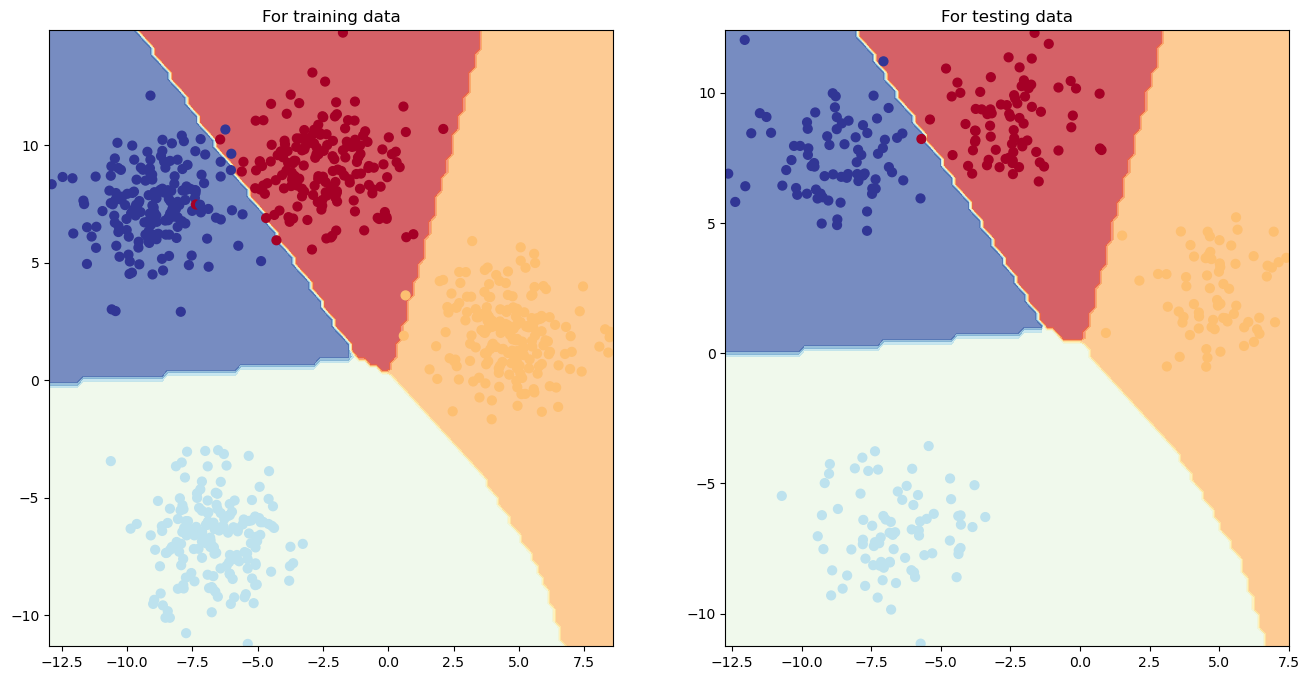

In [726]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('For training data')
plot_decision_boundary(ModelV4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title('For testing data')
plot_decision_boundary(ModelV4, X_blob_test, y_blob_test)

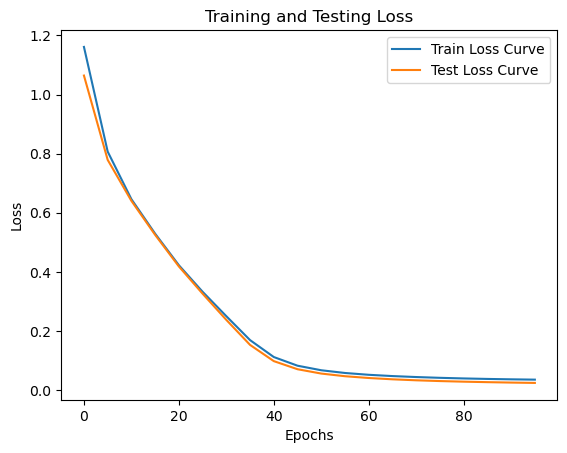

In [727]:
# Plot loss curves
plt.title('Training and Testing Loss')
plt.plot(EPOCH_LIST, torch.tensor(TRAIN_LOSS_LIST).numpy(), label='Train Loss Curve')
plt.plot(EPOCH_LIST, torch.tensor(TEST_LOSS_LIST).numpy(), label='Test Loss Curve')

# plt.plot(torch.tensor(EPOCH_LIST), torch.tensor(TRAIN_LOSS_LIST)), also works

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

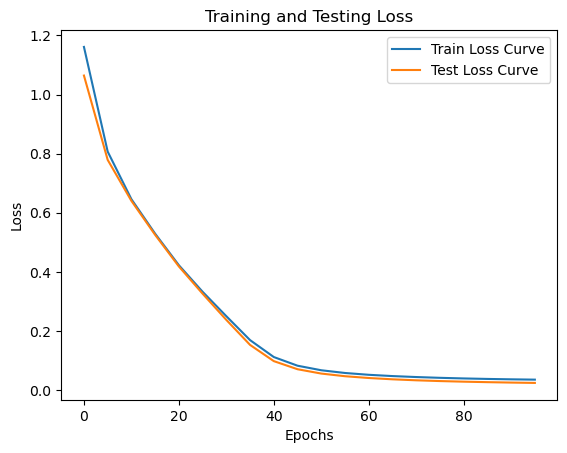

In [728]:
# Plot loss curves
plt.title('Training and Testing Loss')
plt.plot(torch.tensor(EPOCH_LIST), torch.tensor(TRAIN_LOSS_LIST), label='Train Loss Curve')
plt.plot(torch.tensor(EPOCH_LIST), torch.tensor(TEST_LOSS_LIST), label='Test Loss Curve')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### **More Classification Metrics**
Metric Name | Metric Formula | Code | When to Use
- Accuracy, (TP+TN) / (TP+TN+FP+FN), `torchmetrics.Accuracy()`, `sklearn.metrics.accuracy_score()`, Default metric for classification problems, not the best for unbalanced classes

- Precision, TP / (TP+FP), `torchmetrics.Precision()`, `sklearn.metrics.precision_score()`, Higher precision leads to less false positives

- Recall, TP / (TP+FN), `torchmetrics.Recall()`, `sklearn.metrics.recall_score()`, Higher recall leads to less false negatives

*Precision-Recall Tradeoff*

- F1-Score, 2* (Precision*Recall) / (Precision+Recall), `torchmetrics.F1Score()`, `sklearn.metrics.f1_score()`, Combination of precision and recall, is a overall good metric for classification models

- Confusion Matrix, `torch.metrics.ConfusionMatrix()`

- **Classification Report** 

In [743]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='MULTICLASS', num_classes=4).to(device)
# Accuracy function and data to be tested must be on same device

torchmetrics_accuracy(y_pred, y_blob_test)

tensor(0.9933, device='cuda:0')

### **Computer Vision**